### ~ 7 mins

In [1]:
#default_exp normalize

### set `data.yaml`

In [41]:
import yaml,os

In [42]:
os.environ['YAML_DATA']="/home/turgutluk/Vent_Seg_Project/dev/configs/data.yaml"

In [43]:
with open(os.environ.get('YAML_DATA', '../data.yaml')) as f: data_config = yaml.load(f.read(), yaml.FullLoader)

In [44]:
data_config

{'input': {'ATLAS_PATH': '/data/public/PICARE_BMETS_Raw_DICOM_Files',
  'MR_PATH': '/data/public/PICARE_SEGMENTATION_BRAINVENT_MR_V1',
  'CT_PATH': '/data/public/Training_CT_Raw_DICOM_Files',
  'MR_TEST2_PATH': '/data/public/Testing_MR_Raw_DICOM_Files',
  'CT_TEST2_PATH': '/data/public/Testing_CT_Raw_DICOM_Files'},
 'output': {'ATLAS': '/home/turgutluk/data/ventricles_data/atlas',
  'MR': '/home/turgutluk/data/ventricles_data/mr',
  'CT': '/home/turgutluk/data/ventricles_data/ct'},
 'csv_splits': {'ATLAS': '/home/turgutluk/data/ventricles_data/csvs/atlas_splits_df.csv',
  'MR': '/home/turgutluk/data/ventricles_data/csvs/mr_splits_df.csv',
  'CT': '/home/turgutluk/data/ventricles_data/csvs/ct_splits_df.csv'}}

### normalize image and skull_stripped_image for training

In [6]:
#export
from fastai2.medical.imaging_roi import *
from fastai2.medical.imaging import dicom_windows
from fastai2 import *
from fastai2.torch_core import *
from fastai2.core import *
from fastai2.basics import *

In [8]:
from local.dicom2tensor import _plot_voxel

In [9]:
os.environ['YAML_DATA']="/home/turgutluk/Vent_Seg_Project/dev/data.yaml"

In [10]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

In [11]:
# define input and output paths
input_paths = types.SimpleNamespace(
    ATLAS_PATH=data_config['input']['ATLAS_PATH'],
    MR_PATH=data_config['input']['MR_PATH'],
    CT_PATH=data_config['input']['CT_PATH'],
    MR_TEST2_PATH=data_config['input']['MR_TEST2_PATH'],
    CT_TEST2_PATH=data_config['input']['CT_TEST2_PATH'],
)

output_paths = types.SimpleNamespace(
    ATLAS=data_config['output']['ATLAS'],
    MR=data_config['output']['MR'],
    CT=data_config['output']['CT'])

### normalize images

In [12]:
# Normalize images with mean std normalization at every pixel
# Normalize skull stripped images with mean std calculated inside brain region, 
# set non-brain region as 0

In [13]:
#export
def _normalize(t, mean, std):
    "normalization func"
    t = torch.clamp((t - mean) / std, -5, 5)
    _min, _max = torch.min(t), torch.max(t)
    return (t - _min) / (_max - _min)

In [14]:
#export
def _normalize_images_and_save(o):
    "Normalizes individual images to 0-1 scale and save"
    # read image
    t = torch.load(o)
    # normalize
    std,mean = torch.std_mean(t)
    t = _normalize(t, mean, std)
    # save
    p = o.parent
    suid = o.name.split('_')[0]
    torch.save(t, p/f"{suid}_image_normalized.pt")

### normalized skull stripped images

In [15]:
#export
def _normalize_skull_stripped_images_and_save(o):
    "Normalizes individual skull stripped images to 0-1 scale and save"
    # read image and mask
    t = torch.load(o)
    p = o.parent
    suid = o.name.split('_')[0]
    msk = torch.load(p/f"{suid}_brain_mask.pt")
    # normalize
    std,mean = torch.std_mean(t[msk.bool()])
    t = _normalize(t, mean, std)*msk
    # save
    torch.save(t, p/f"{suid}_skull_stripped_image_normalized.pt")

### `[notebook run #1]` - `normalize`

You can use the following cells to normalize image and skull stripped image tensors. Code below will get all the files in a given output path which we saved our tensors in previous sections: dicom2tensor and skullstrip. You may choose ATLAS, MR, CT output_paths for normalization or you can also pass a parent directory if you saved all outputs to the same parent directory as it is suggested.

We normalize images and skull stripped image differently. Since skull stripped images only concentrate on brain region pixel mean and std statistics are calculate only using those pixels and anything outside is left as 0.

In [16]:
# I can either go with a specific modality directory
output_path = output_paths.MR; print(output_path)
# or I can use parent directory which is same in my case for MR, CT and ATLAS to skull strip all data in one go
output_path = Path(output_paths.MR).parent; print(output_path)

/home/turgutluk/data/ventricles_data/mr
/home/turgutluk/data/ventricles_data


In [28]:
# collect all files
files = get_files(output_path, extensions=['.pt'])
# collect all images and skull stripped imags
image_files = [o for o in files if "_".join(o.name.split("_")[1:]) == "image.pt"]
skull_stripped_image_files = [o for o in files if "_".join(o.name.split("_")[1:]) == "skull_stripped_image.pt"]

In [29]:
len(image_files), len(skull_stripped_image_files)

(2501, 2501)

In [21]:
# 3 mins: normalize images
parallel(_normalize_images_and_save, image_files, n_workers=defaults.cpus//2)

(#2501) [None,None,None,None,None,None,None,None,None,None...]

In [22]:
# 4 mins: normalize skull stripped images
parallel(_normalize_skull_stripped_images_and_save, skull_stripped_image_files, n_workers=defaults.cpus//2)

(#2501) [None,None,None,None,None,None,None,None,None,None...]

### `script` - Don't execute cells below!

These cells are converted into a python script in `local/normalize.py` which you can use instead of running in noteboook

In [30]:
#export 
import yaml
with open(os.environ.get('YAML_DATA', '../data.yaml')) as f: data_config = yaml.load(f.read(), yaml.FullLoader)

# define input and output paths
input_paths = types.SimpleNamespace(
    ATLAS_PATH=data_config['input']['ATLAS_PATH'],
    MR_PATH=data_config['input']['MR_PATH'],
    CT_PATH=data_config['input']['CT_PATH'],
    MR_TEST2_PATH=data_config['input']['MR_TEST2_PATH'],
    CT_TEST2_PATH=data_config['input']['CT_TEST2_PATH'],
)

output_paths = types.SimpleNamespace(
    ATLAS=data_config['output']['ATLAS'],
    MR=data_config['output']['MR'],
    CT=data_config['output']['CT'])

In [ ]:
#export 
from time import perf_counter
@call_parse
def main(output_path:Param("Directory that have data prep results", str)):
    "Read tensors, normalize images and skull stripped images"
    start = perf_counter()
    
    output_path = Path(output_paths.__dict__[output_path])
    files = get_files(output_path, extensions=['.pt'])
    image_files = [o for o in files if "_".join(o.name.split("_")[1:]) == "image.pt"]
    skull_stripped_image_files = [o for o in files if "_".join(o.name.split("_")[1:]) == "skull_stripped_image.pt"]
    parallel(_normalize_images_and_save, image_files, n_workers=defaults.cpus//2)
    parallel(_normalize_skull_stripped_images_and_save, skull_stripped_image_files, n_workers=defaults.cpus//2)
    
    end = perf_counter()
    print(f"Total time taken {end-start} seconds")

### Export

In [47]:
from local.notebook.export import notebook2script
notebook2script("1c) normalization.ipynb")

Converted 1c) normalization.ipynb.


### Visualize

You may visualize normalized image and skull stripped images

In [32]:
# pick a random file
files = get_files(output_path, extensions=['.pt'])
o = np.random.choice(files)

In [33]:
# extract study instance uid
suid = o.name.split("_")[0]
p = o.parent

In [35]:
# read image and skull stripped image for that study instance
skull_stripped_image = torch.load(p/f"{suid}_skull_stripped_image_normalized.pt")
image = torch.load(p/f"{suid}_image_normalized.pt")

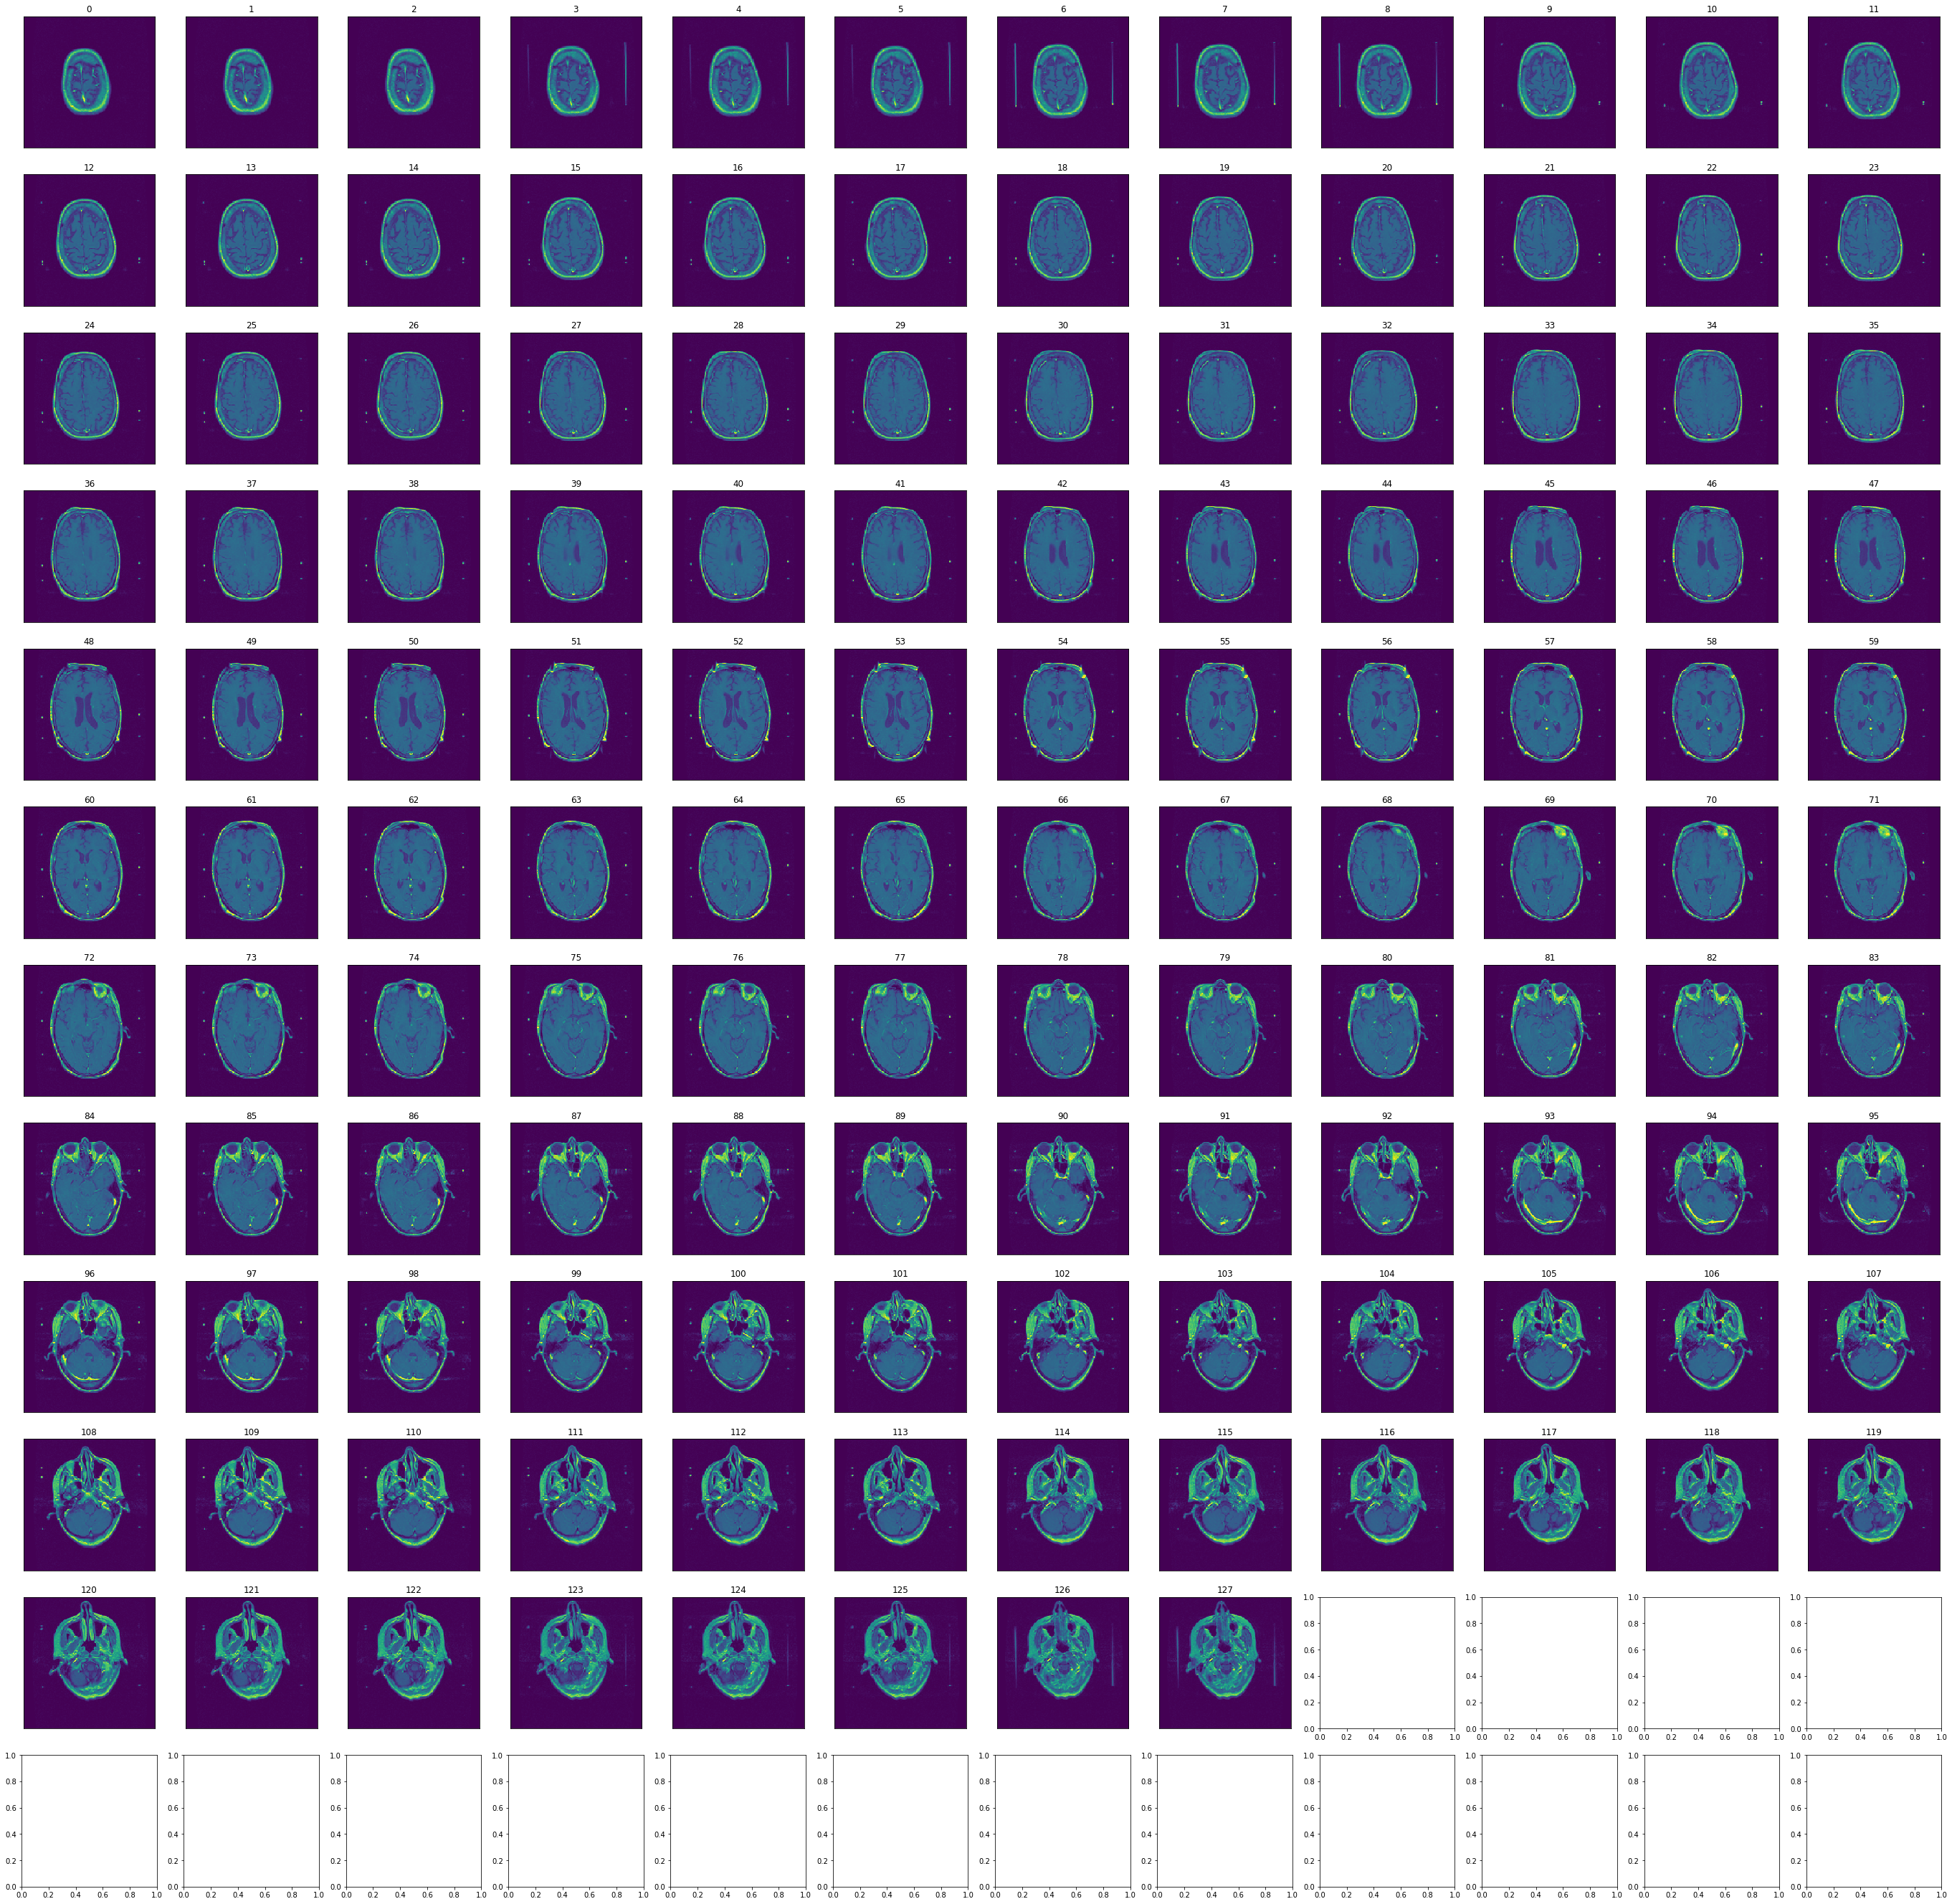

In [36]:
_plot_voxel(image)

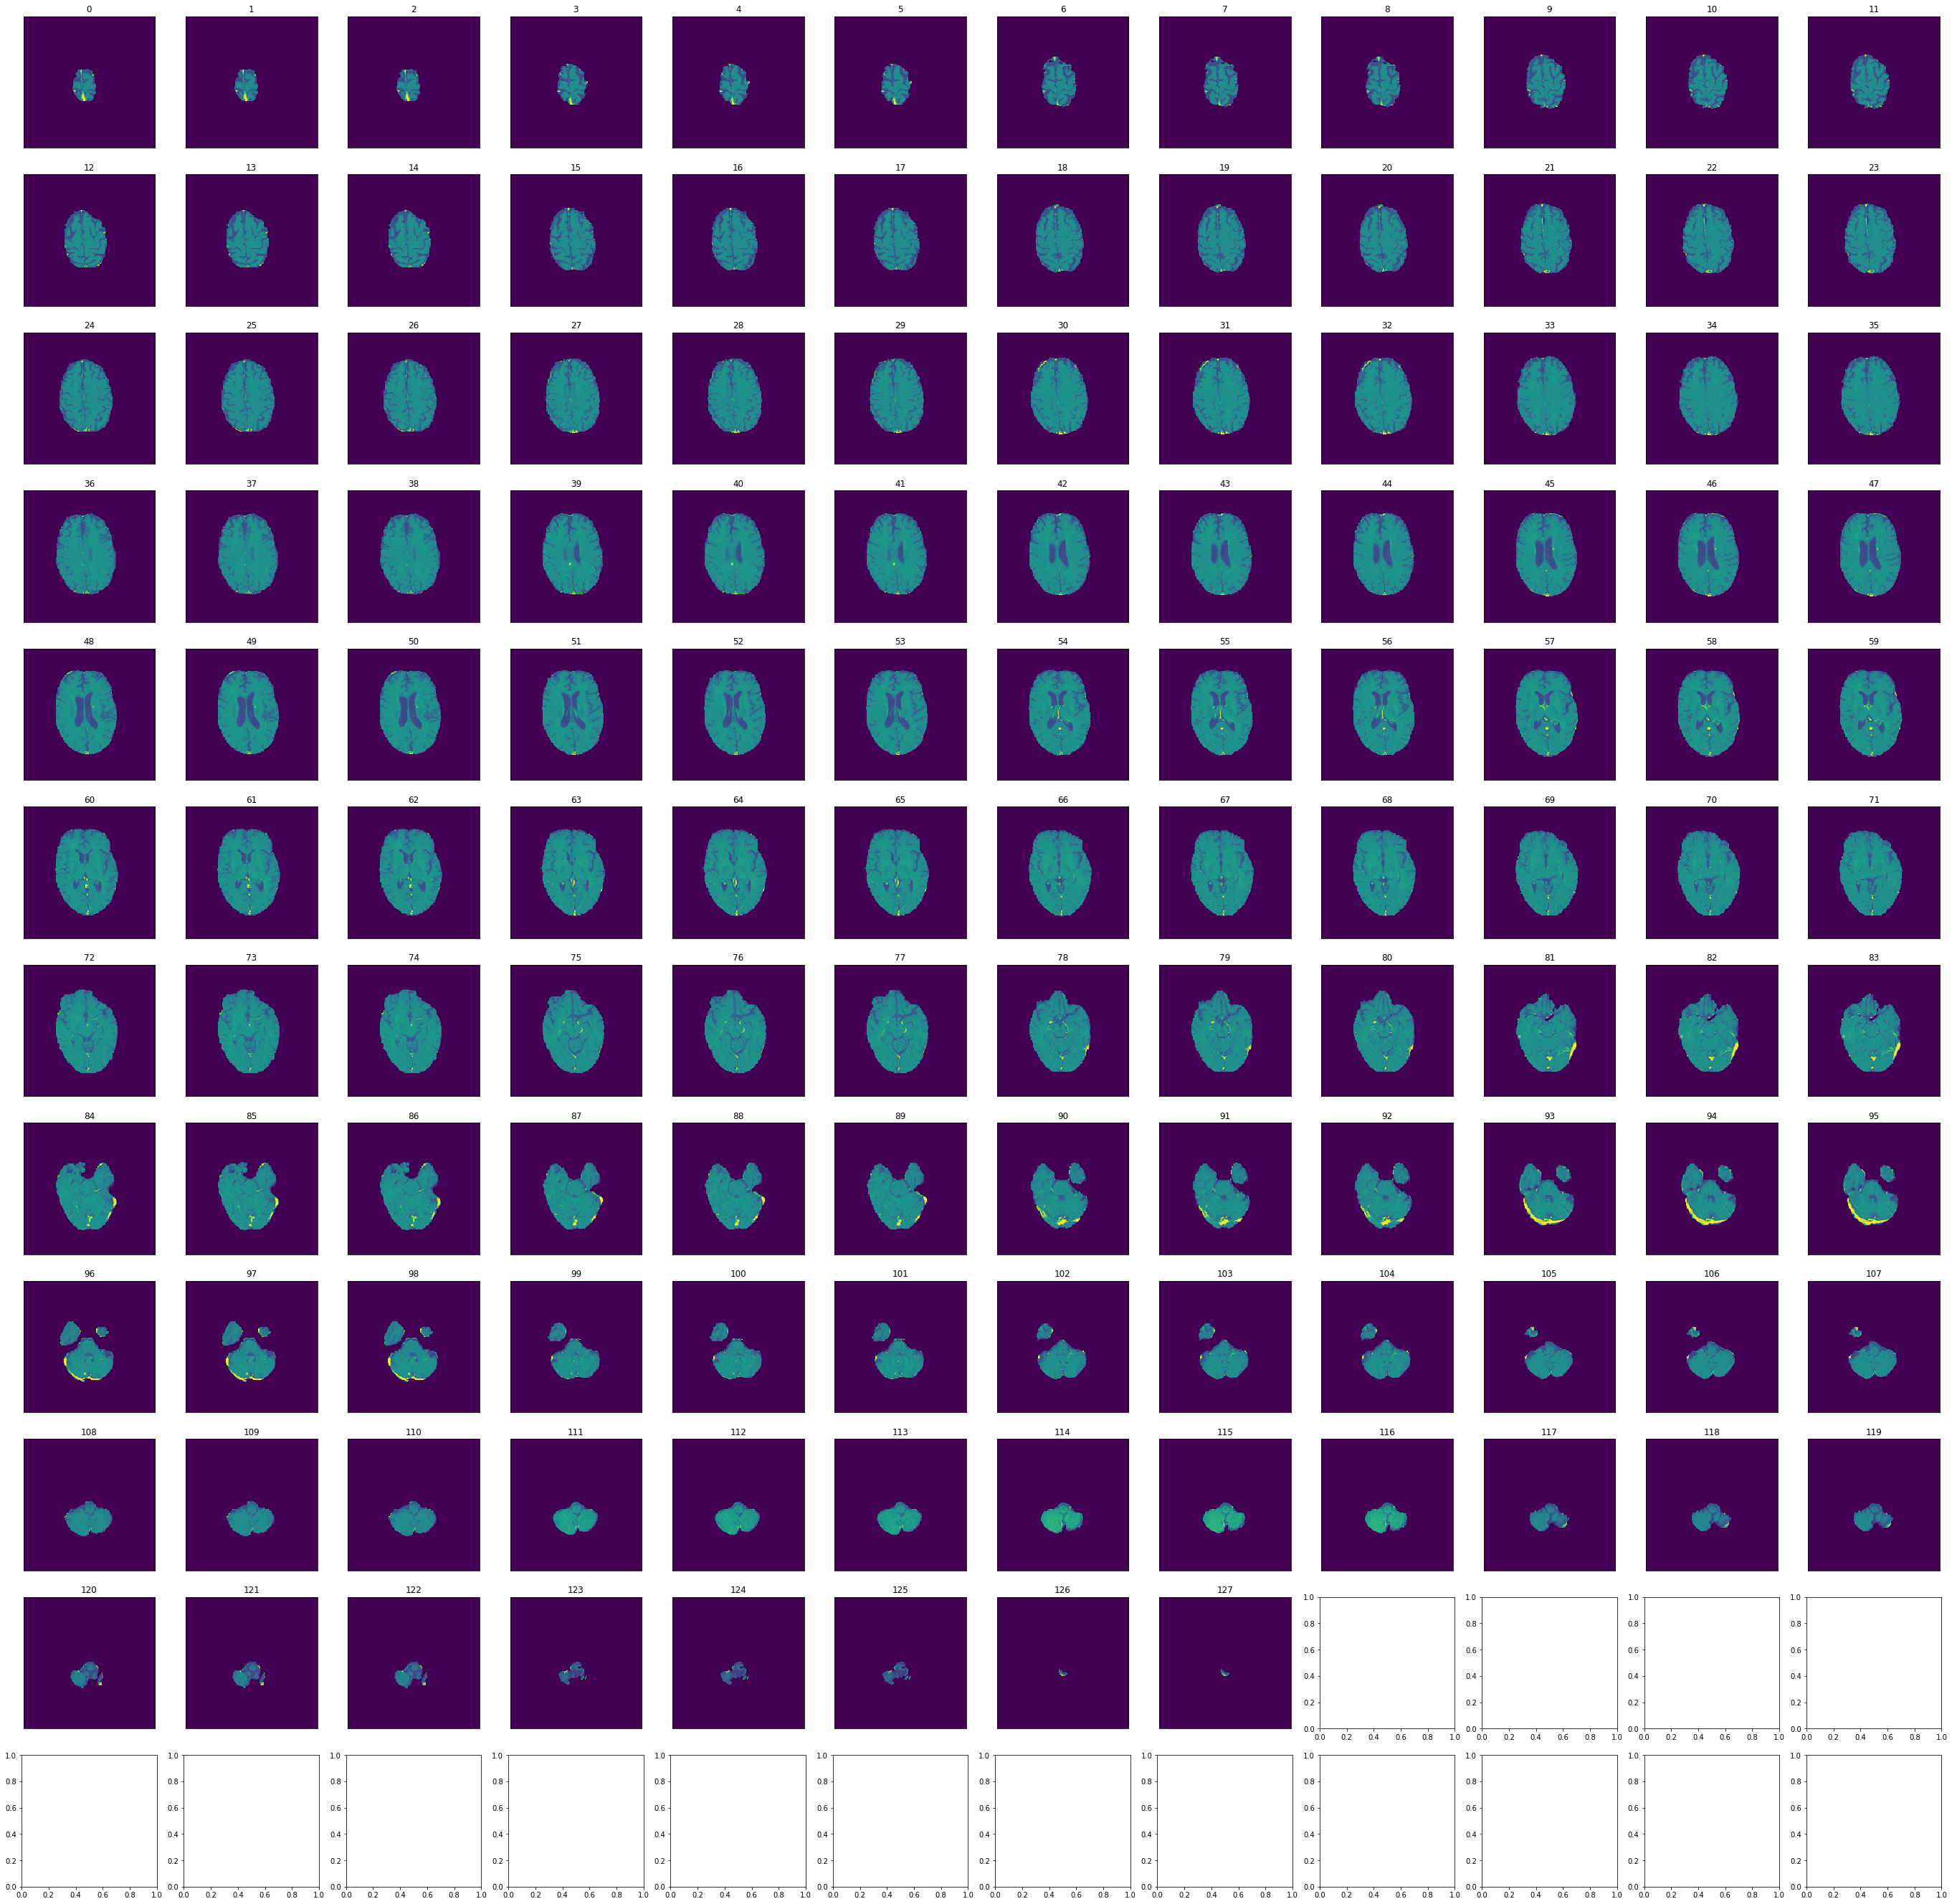

In [37]:
_plot_voxel(skull_stripped_image)

### fin